In [1]:
import torch
import torch.nn as nn
import keras
import tensorflow_datasets as tfds
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
import condense
condense.logger.setLevel("INFO")


ds_train, ds_test = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, as_supervised=True)
def generator(batch_size, data_set):
    while True:
        X, y = next(tfds.as_numpy(data_set.batch(batch_size).cache()))
        yield torch.Tensor(X.reshape(batch_size, 1, 28,28)), torch.Tensor(y).type(torch.LongTensor)
gen = generator(300, ds_train)
gen_test = generator(250, ds_test)

# Model Definition

In [2]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.layer1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, stride=2)
        self.layer2 = nn.Conv2d(in_channels=4, out_channels=2, kernel_size=2)
        self.dense = nn.Linear(288, out_features=50)
        self.output = nn.Linear(50, out_features=10)
    

    def forward(self, X):
        X = self.layer1.forward(X)
        X = self.layer2.forward(torch.relu(X))
        X = X.view(torch.relu(X).size(0), -1)
        X = self.dense.forward(torch.relu(X))
        X = self.output.forward(torch.relu(X))
        X = torch.log_softmax(X, 1)
        return X
    
    def train(self, d, epochs=20):
        criterion = nn.CrossEntropyLoss()
        optim = torch.optim.SGD(self.parameters(), lr=0.01, weight_decay=0.1)
        
        for _ in range(epochs):
            X, y = next(d)
            for _ in range(20):
                self.zero_grad()
                pred = self.forward(X)
                l = criterion(pred, y)
                l.backward()
                optim.step()
            print('Training Loss:', float(l))
            
net = Network()

# Apply `PruningAgent` module to your model

As we can see, no pruning has happened yet and all sparsity masks are initialized to `1`.

In [3]:
pruned = condense.torch.PruningAgent(net, condense.optimizer.sparsity_functions.Constant(0.8))   
f'Parameter Sparsity: {pruned.get_parameter_sparsity()}'

'Parameter Sparsity: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]'

# Start the ticket search process
The ticket search process is training operation agnostic, so you are free to use whatever you like to train your model.
On `TicketSearch` entry all model parameters get saved for reinitialization later on.
On exit, parameters get reinitialized to their original values and masks get applied.

In [4]:
with condense.torch.TicketSearch(pruned):
    pruned.model.train(gen, 10)  
    
f'Parameter Sparsity: {pruned.get_parameter_sparsity()}'    

INFO:condense:💾 Storing module parameters for reinitialization
INFO:condense:🔬 Searching for winning ticket


Training Loss: 2.156653881072998
Training Loss: 0.8623332977294922
Training Loss: 0.19363929331302643
Training Loss: 0.056067198514938354
Training Loss: 0.027829818427562714
Training Loss: 0.020469684153795242
Training Loss: 0.014686280861496925
Training Loss: 0.01255014818161726
Training Loss: 0.011361232958734035


INFO:condense:🎟 Winning ticket found
INFO:condense:⚙️ Generating Mask
INFO:condense:😄 Reinitialized module parameters
INFO:condense:🥷 Ticket masks applied to module parameters


Training Loss: 0.011917770840227604


'Parameter Sparsity: [0.8125, 1.0, 0.8125, 1.0, 0.8000694444444445, 0.82, 0.802, 0.9]'

# Start the actual training on the pruned model

Training Loss: 0.45609796047210693
Training Loss: 0.24220678210258484
Training Loss: 0.1433119773864746
Training Loss: 0.09626256674528122
Training Loss: 0.06380551308393478
Training Loss: 0.04837682098150253
Training Loss: 0.03928240016102791
Training Loss: 0.033478058874607086
Training Loss: 0.02960151433944702
Training Loss: 0.026925450190901756
Parameter Sparsity: [0.8125, 1.0, 0.8125, 1.0, 0.8000694444444445, 0.82, 0.802, 0.9]


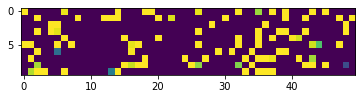

In [5]:
pruned.model.train(gen, 10) 
print(f'Parameter Sparsity: {pruned.get_parameter_sparsity()}') 
plt.imshow(np.abs(pruned.model.output.weight.detach().numpy()), vmin=0, vmax=.1)